## MNIST를 이용해 MLP + Dropout 

In [2]:
#1. 필요한 모듈 import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
#2. 딥러닝 모델을 설계할 때 활용하는 cuda 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
else :
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version : ', torch.__version__, '  Device : ', DEVICE)

Using PyTorch version :  1.8.0   Device :  cuda:0


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
train = datasets.MNIST(root='C:/Users/HeoJiHae/Desktop/허지혜/파이썬딥러닝파이토치/data',train=True, download=True,
                      transform=transforms.ToTensor())
test = datasets.MNIST(root='C:/Users/HeoJiHae/Desktop/허지혜/파이썬딥러닝파이토치/data',train=False,transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=BATCH_SIZE,
                                           shuffle=False)

In [6]:
for (X_train, y_train) in train_loader :
    print("X_train", X_train.shape, "y_train", y_train.shape)
    break

X_train torch.Size([32, 1, 28, 28]) y_train torch.Size([32])


In [10]:
#4. MLP 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        self.dropout_prob = 0.5
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

training = self.training 부분은 학습 상태일 때와 검증 상태에 따라 다르게 적용되기 위해 존재하는 파라미터이다. Dropout은 학습 과정 속에서 랜덤으로 노드를 선택해 가중값이 업데이트되지 않도록 조정하지만 평가 과정 속에서는 모든 노드를 이용해 output을 계산하기 때문에 학습 상태와 검증 상태에서 다르게 적용되야 한다.
이를 반영하기 위한 파라미터 값을 model.train()으로 명시할 때 self.training = True, model.eval()으로 명시할 때 self.trainig = False로 적용한다. 

In [11]:
#5. Optimizer, Loss Function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#https://codedragon.tistory.com/9466
# optimizer의 관성을 나타내는 momentum
# 관성의 방향을 고려해 진동과 폭을 줄이는 효과를 나타낸다.
# momentum을 설정해주므로써 정확도를 개선할 수 있다.
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [12]:
#6. MLP 모델 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는
# 함수 정의
def train(model,train_loader, optimizer,log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader): #(1)
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #(2)
        output = model(image)
        loss = criterion(output, label)
        loss.backward() #(3)
        optimizer.step() #(4)
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)] Train Loss : {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.* batch_idx / len(train_loader),
            loss.item()))

In [13]:
#7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): #(1)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] #(2)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy 

In [14]:
#8. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test Accuracy를 확인하자.
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f}, Test Accuracy : {:.2f} ".
         format(Epoch, test_loss, test_accuracy))

C:\Users\HeoJiHae\Anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch : 1 [0/60000(0%)] Train Loss : 2.383194
Train Epoch : 1 [6400/60000(11%)] Train Loss : 2.361921
Train Epoch : 1 [12800/60000(21%)] Train Loss : 2.322273
Train Epoch : 1 [19200/60000(32%)] Train Loss : 2.351015
Train Epoch : 1 [25600/60000(43%)] Train Loss : 2.292918
Train Epoch : 1 [32000/60000(53%)] Train Loss : 2.264077
Train Epoch : 1 [38400/60000(64%)] Train Loss : 2.324771
Train Epoch : 1 [44800/60000(75%)] Train Loss : 2.361111
Train Epoch : 1 [51200/60000(85%)] Train Loss : 2.303666
Train Epoch : 1 [57600/60000(96%)] Train Loss : 2.317348
|n[EPOCH :1], Test Loss : 0.0712, Test Accuracy : 11.51 
Train Epoch : 2 [0/60000(0%)] Train Loss : 2.320145
Train Epoch : 2 [6400/60000(11%)] Train Loss : 2.297515
Train Epoch : 2 [12800/60000(21%)] Train Loss : 2.301123
Train Epoch : 2 [19200/60000(32%)] Train Loss : 2.233465
Train Epoch : 2 [25600/60000(43%)] Train Loss : 2.335407
Train Epoch : 2 [32000/60000(53%)] Train Loss : 2.237577
Train Epoch : 2 [38400/60000(64%)] Train Lo

In [19]:
import numpy as np
test_accuracy

86.97

## MNIST를 이용해 MLP + Dropout  + ReLU

In [15]:
#4. MLP 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        self.dropout_prob = 0.5
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [20]:
#5. Optimizer, Loss Function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#https://codedragon.tistory.com/9466
# optimizer의 관성을 나타내는 momentum
# 관성의 방향을 고려해 진동과 폭을 줄이는 효과를 나타낸다.
# momentum을 설정해주므로써 정확도를 개선할 수 있다.
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [21]:
#6. MLP 모델 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는
# 함수 정의
def train(model,train_loader, optimizer,log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader): #(1)
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #(2)
        output = model(image)
        loss = criterion(output, label)
        loss.backward() #(3)
        optimizer.step() #(4)
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)] Train Loss : {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.* batch_idx / len(train_loader),
            loss.item()))

In [22]:
#7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): #(1)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] #(2)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy 

In [23]:
#8. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test Accuracy를 확인하자.
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f}, Test Accuracy : {:.2f} ".
         format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/60000(0%)] Train Loss : 2.316803
Train Epoch : 1 [6400/60000(11%)] Train Loss : 2.073781
Train Epoch : 1 [12800/60000(21%)] Train Loss : 1.320775
Train Epoch : 1 [19200/60000(32%)] Train Loss : 0.985038
Train Epoch : 1 [25600/60000(43%)] Train Loss : 0.691933
Train Epoch : 1 [32000/60000(53%)] Train Loss : 0.554691
Train Epoch : 1 [38400/60000(64%)] Train Loss : 0.534148
Train Epoch : 1 [44800/60000(75%)] Train Loss : 0.297812
Train Epoch : 1 [51200/60000(85%)] Train Loss : 0.437754
Train Epoch : 1 [57600/60000(96%)] Train Loss : 0.239707
|n[EPOCH :1], Test Loss : 0.0103, Test Accuracy : 90.80 
Train Epoch : 2 [0/60000(0%)] Train Loss : 0.249617
Train Epoch : 2 [6400/60000(11%)] Train Loss : 0.346802
Train Epoch : 2 [12800/60000(21%)] Train Loss : 0.421805
Train Epoch : 2 [19200/60000(32%)] Train Loss : 0.489820
Train Epoch : 2 [25600/60000(43%)] Train Loss : 0.347218
Train Epoch : 2 [32000/60000(53%)] Train Loss : 0.190463
Train Epoch : 2 [38400/60000(64%)] Train Lo

## MNIST를 이용해 MLP + Dropout  + ReLU + BN

비선형 함수는 출력값을 변경 시키는 함수로 대표적으로 ReLU 함수가 있다. ReLU 함수는 input 값이 0 미만이면 0으로 0 이상이면 그 값이 그대로 출력된다. 이때 Batch Normalization을 사용하지 않는다면 hidden layer를 쌓으면서 비선형 활성 함수를 사용하는 의미가 없어질 가능성이 있다. BN의 분포를 정규화해 비선형 활성 함수의 의미를 살리는 개념.

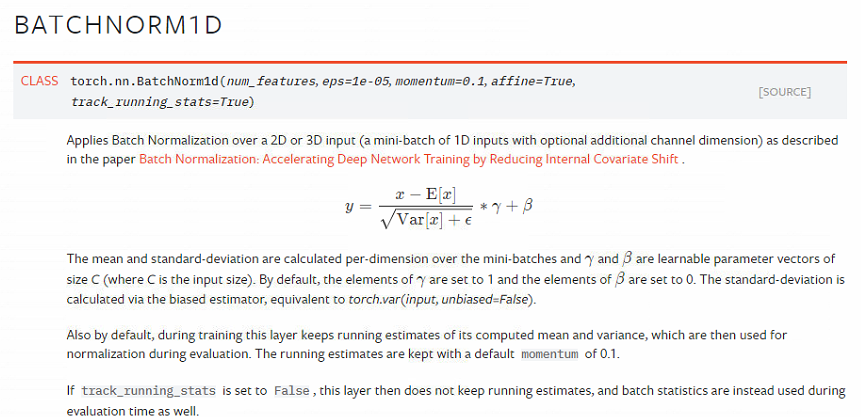

In [26]:
#4. MLP 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [27]:
#5. Optimizer, Loss Function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#https://codedragon.tistory.com/9466
# optimizer의 관성을 나타내는 momentum
# 관성의 방향을 고려해 진동과 폭을 줄이는 효과를 나타낸다.
# momentum을 설정해주므로써 정확도를 개선할 수 있다.
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [28]:
#6. MLP 모델 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는
# 함수 정의
def train(model,train_loader, optimizer,log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader): #(1)
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #(2)
        output = model(image)
        loss = criterion(output, label)
        loss.backward() #(3)
        optimizer.step() #(4)
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)] Train Loss : {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.* batch_idx / len(train_loader),
            loss.item()))

In [29]:
#7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): #(1)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] #(2)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy 

In [30]:
#8. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test Accuracy를 확인하자.
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f}, Test Accuracy : {:.2f} ".
         format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/60000(0%)] Train Loss : 2.463778
Train Epoch : 1 [6400/60000(11%)] Train Loss : 0.467663
Train Epoch : 1 [12800/60000(21%)] Train Loss : 0.602977
Train Epoch : 1 [19200/60000(32%)] Train Loss : 0.475483
Train Epoch : 1 [25600/60000(43%)] Train Loss : 0.492573
Train Epoch : 1 [32000/60000(53%)] Train Loss : 0.107300
Train Epoch : 1 [38400/60000(64%)] Train Loss : 0.296278
Train Epoch : 1 [44800/60000(75%)] Train Loss : 0.329317
Train Epoch : 1 [51200/60000(85%)] Train Loss : 0.219723
Train Epoch : 1 [57600/60000(96%)] Train Loss : 0.280111
|n[EPOCH :1], Test Loss : 0.0049, Test Accuracy : 95.21 
Train Epoch : 2 [0/60000(0%)] Train Loss : 0.129653
Train Epoch : 2 [6400/60000(11%)] Train Loss : 0.320743
Train Epoch : 2 [12800/60000(21%)] Train Loss : 0.572319
Train Epoch : 2 [19200/60000(32%)] Train Loss : 0.241588
Train Epoch : 2 [25600/60000(43%)] Train Loss : 0.248528
Train Epoch : 2 [32000/60000(53%)] Train Loss : 0.159517
Train Epoch : 2 [38400/60000(64%)] Train Lo

## MNIST를 이용해 MLP + Dropout  + ReLU + BN + He Uniform Initialization

In [31]:
#4. MLP 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [32]:
#5. Optimizer, Loss Function 설정
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weignt.data)
    
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#https://codedragon.tistory.com/9466
# optimizer의 관성을 나타내는 momentum
# 관성의 방향을 고려해 진동과 폭을 줄이는 효과를 나타낸다.
# momentum을 설정해주므로써 정확도를 개선할 수 있다.
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [33]:
#6. MLP 모델 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는
# 함수 정의
def train(model,train_loader, optimizer,log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader): #(1)
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #(2)
        output = model(image)
        loss = criterion(output, label)
        loss.backward() #(3)
        optimizer.step() #(4)
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)] Train Loss : {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.* batch_idx / len(train_loader),
            loss.item()))

In [34]:
#7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): #(1)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] #(2)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy 

In [35]:
#8. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test Accuracy를 확인하자.
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f}, Test Accuracy : {:.2f} ".
         format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/60000(0%)] Train Loss : 2.734238
Train Epoch : 1 [6400/60000(11%)] Train Loss : 0.692841
Train Epoch : 1 [12800/60000(21%)] Train Loss : 0.688905
Train Epoch : 1 [19200/60000(32%)] Train Loss : 0.207404
Train Epoch : 1 [25600/60000(43%)] Train Loss : 0.527945
Train Epoch : 1 [32000/60000(53%)] Train Loss : 0.214143
Train Epoch : 1 [38400/60000(64%)] Train Loss : 0.570171
Train Epoch : 1 [44800/60000(75%)] Train Loss : 0.384477
Train Epoch : 1 [51200/60000(85%)] Train Loss : 0.109870
Train Epoch : 1 [57600/60000(96%)] Train Loss : 0.098868
|n[EPOCH :1], Test Loss : 0.0047, Test Accuracy : 95.53 
Train Epoch : 2 [0/60000(0%)] Train Loss : 0.129960
Train Epoch : 2 [6400/60000(11%)] Train Loss : 0.267232
Train Epoch : 2 [12800/60000(21%)] Train Loss : 0.195476
Train Epoch : 2 [19200/60000(32%)] Train Loss : 0.173938
Train Epoch : 2 [25600/60000(43%)] Train Loss : 0.270691
Train Epoch : 2 [32000/60000(53%)] Train Loss : 0.260662
Train Epoch : 2 [38400/60000(64%)] Train Lo

## MNIST를 이용해 MLP + Dropout  + ReLU + BN + He Uniform Initialization + Adam

In [36]:
#4. MLP 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training , p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [38]:
#5. Optimizer, Loss Function 설정
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weignt.data)
    
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01)
#https://codedragon.tistory.com/9466
# optimizer의 관성을 나타내는 momentum
# 관성의 방향을 고려해 진동과 폭을 줄이는 효과를 나타낸다.
# momentum을 설정해주므로써 정확도를 개선할 수 있다.
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [39]:
#6. MLP 모델 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는
# 함수 정의
def train(model,train_loader, optimizer,log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader): #(1)
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #(2)
        output = model(image)
        loss = criterion(output, label)
        loss.backward() #(3)
        optimizer.step() #(4)
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)] Train Loss : {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.* batch_idx / len(train_loader),
            loss.item()))

In [40]:
#7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): #(1)
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] #(2)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy 

In [41]:
#8. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test Accuracy를 확인하자.
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f}, Test Accuracy : {:.2f} ".
         format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/60000(0%)] Train Loss : 2.375663
Train Epoch : 1 [6400/60000(11%)] Train Loss : 0.475244
Train Epoch : 1 [12800/60000(21%)] Train Loss : 0.290172
Train Epoch : 1 [19200/60000(32%)] Train Loss : 0.988470
Train Epoch : 1 [25600/60000(43%)] Train Loss : 0.294957
Train Epoch : 1 [32000/60000(53%)] Train Loss : 0.273144
Train Epoch : 1 [38400/60000(64%)] Train Loss : 0.276950
Train Epoch : 1 [44800/60000(75%)] Train Loss : 0.158014
Train Epoch : 1 [51200/60000(85%)] Train Loss : 0.352204
Train Epoch : 1 [57600/60000(96%)] Train Loss : 0.432386
|n[EPOCH :1], Test Loss : 0.0040, Test Accuracy : 95.95 
Train Epoch : 2 [0/60000(0%)] Train Loss : 0.494424
Train Epoch : 2 [6400/60000(11%)] Train Loss : 0.219006
Train Epoch : 2 [12800/60000(21%)] Train Loss : 0.126103
Train Epoch : 2 [19200/60000(32%)] Train Loss : 0.644363
Train Epoch : 2 [25600/60000(43%)] Train Loss : 0.249119
Train Epoch : 2 [32000/60000(53%)] Train Loss : 0.066267
Train Epoch : 2 [38400/60000(64%)] Train Lo